In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install datasets transformers evaluate jiwer -q

In [4]:
import torch
import datasets
from datasets import Audio
import evaluate
import numpy as np
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperProcessor
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments

from transformers import AutoModelForCTC
from transformers import TrainingArguments
from transformers import Trainer

In [5]:
ds = datasets.load_dataset("mozilla-foundation/common_voice_11_0", 
                           name="as", 
                           split="train+test")

In [6]:
ds = ds.cast_column("audio", Audio(sampling_rate=16_000))

In [7]:
model_path="openai/whisper-tiny"

In [8]:
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_path)
tokenizer = WhisperTokenizer.from_pretrained(model_path, language="Assamese", task="transcribe")
processor = WhisperProcessor.from_pretrained(model_path, language="Assamese", task="transcribe")

In [9]:
s1 = ds[0]
s1

{'client_id': 'af73187438537bf78a33930717694a696d489072f8e334e9a21dd46fa09ae9c3040e4d44e97e8c2bea2bfda5d74e73063f486d36ca84f4bfc56b43a58bb9389b',
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/fdcfd174c1db561f74a5aab292ff32458ceffd67c10de1ac5f5b77eae211090c/as_train_0/common_voice_as_22074894.mp3',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/fdcfd174c1db561f74a5aab292ff32458ceffd67c10de1ac5f5b77eae211090c/as_train_0/common_voice_as_22074894.mp3',
  'array': array([ 5.29395592e-23, -6.61744490e-23,  1.48892510e-22, ...,
          1.20360312e-07, -1.29233990e-06, -1.51768404e-06]),
  'sampling_rate': 16000},
 'sentence': 'দেখিলে যে অসমীয়া মানুহৰ জ্ঞান-উন্নতি পিনে অলপাে মনকাণ নাই',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'as',
 'segment': ''}

In [10]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array 
    batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    # compute input length of audio sample in seconds
    batch["input_length"] = len(audio["array"]) / audio["sampling_rate"]
    # encode target text to label ids 
    batch["labels"] = processor.tokenizer(batch["sentence"]).input_ids
    return batch

In [11]:
# tokenizer(s1["sentence"])
# feature_extractor(s1["audio"]["array"], sampling_rate=s1["audio"]["sampling_rate"]).input_features[0].shape

In [12]:
cvds = ds.map(prepare_dataset, remove_columns=ds.column_names, num_proc=4)

In [13]:
test_set = cvds.select(range(10))
train_set = cvds.select(range(10, len(cvds)))

In [14]:
train_set, test_set

(Dataset({
     features: ['input_features', 'input_length', 'labels'],
     num_rows: 1122
 }),
 Dataset({
     features: ['input_features', 'input_length', 'labels'],
     num_rows: 10
 }))

In [48]:
model = WhisperForConditionalGeneration.from_pretrained(model_path)

In [49]:
# forced decoder ids to none
model.generation_config.language = "assamese"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None
model.config.forced_decoder_ids = None
# set language to assamese, task to asr

In [50]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [51]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor
)

In [52]:
model.config.decoder_start_token_id

50258

In [53]:
# data_collator(test_set.select(range(2)))?

In [54]:
wer_metric = evaluate.load("wer")

In [55]:
def compute_metric(pred):
#     pred_logits = pred.predictions
#     pred_ids = np.argmax(pred_logits, axis=-1)
    pred_ids = pred.predictions

    pred.label_ids[pred.label_ids==-100] = processor.tokenizer.pad_token_id

    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     # we do not want to group tokens when computing the metrics
    label_str = processor.tokenizer.batch_decode(pred.label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, referecnes=label_str)
    return {"wer":wer}

In [56]:
# from transformers import Seq2SeqTrainingArguments

# training_args = Seq2SeqTrainingArguments(
#     output_dir="./whisper-tiny-as",  # change to a repo name of your choice
#     per_device_train_batch_size=8,
#     gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
#     learning_rate=1e-5,
#     warmup_steps=50,
#     max_steps=100,
#     fp16=True,
#     eval_strategy="steps",
#     per_device_eval_batch_size=1,
#     predict_with_generate=True,
#     generation_max_length=225,
#     save_steps=100,
#     eval_steps=100,
#     logging_steps=25,
#     load_best_model_at_end=True,
#     metric_for_best_model="wer",
#     greater_is_better=False,
# )


In [57]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-hi",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=50,
    max_steps=100,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=1,
#     predict_with_generate=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
    report_to="none",
    label_names=["labels"]
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [58]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model.to("cuda:0"),
    train_dataset=train_set,
    eval_dataset=test_set,
    data_collator=data_collator,
    compute_metrics=compute_metric,
    tokenizer=processor.tokenizer,
)


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


In [59]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [60]:
dss = datasets.load_dataset("mozilla-foundation/common_voice_11_0", 
                           name="as",
                            split="train")

dss

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
    num_rows: 824
})

In [81]:
#Q2: How many unique characters are there in the train split text ?

sent = " ".join(dss["sentence"])

In [77]:
# sent

In [82]:
chars=set()

In [83]:
for char in sent:
    chars.add(char)

In [84]:
len(chars)

74

In [86]:
# 3
dss[0]["audio"]["sampling_rate"]

48000

In [85]:
# Q4
dss[0]

{'client_id': 'af73187438537bf78a33930717694a696d489072f8e334e9a21dd46fa09ae9c3040e4d44e97e8c2bea2bfda5d74e73063f486d36ca84f4bfc56b43a58bb9389b',
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/fdcfd174c1db561f74a5aab292ff32458ceffd67c10de1ac5f5b77eae211090c/as_train_0/common_voice_as_22074894.mp3',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/fdcfd174c1db561f74a5aab292ff32458ceffd67c10de1ac5f5b77eae211090c/as_train_0/common_voice_as_22074894.mp3',
  'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.51620850e-06, -1.28747206e-06, -6.44893703e-07]),
  'sampling_rate': 48000},
 'sentence': 'দেখিলে যে অসমীয়া মানুহৰ জ্ঞান-উন্নতি পিনে অলপাে মনকাণ নাই',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'as',
 'segment': ''}

## Q5  

What will be the window length in msec if n fft is 400 in ”WhisperFeatureExtractor” ?

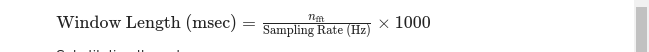

In [87]:
# Q5
400*1000/16000

25.0

In [89]:
# Q6 : What is the first token number after tokenising the 56th example?
processor.tokenizer(ds[55]["sentence"]).input_ids[0]

50258

In [101]:
# Q7:  What is the token corresponding to the token number 51833 in whisper?
processor.tokenizer.added_tokens_decoder[51833]

AddedToken("<|29.38|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False)

In [104]:
# #Q8 Is token number 51833 ("<|29.38|>") a special token?
"<|29.38|>" in processor.tokenizer.all_special_tokens

False

In [105]:
# Q9: What is the token corresponding to the token number 50350 in whisper?

processor.tokenizer.added_tokens_decoder[50350]

AddedToken("<|as|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True)

In [106]:
# Q10: Is token number 50350 a special token?

"<|as|>" in processor.tokenizer.all_special_tokens

True

https://huggingface.co/blog/fine-tune-whisper#prepare-feature-extractor-tokenizer-and-data